## Introduction
This tutorial shows how to use tensorflow to train a neural network to mimic the $\neg (x_1 \oplus x_2)$ function. This function, abbreviated as XNOR, returns 1 only if $x_1$ is equal to $x_2$. The values are summarized in the table below:

$$
\begin{array}{c|c|c}
x_1 & x_2 & y \\ \hline
0 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 0 \\
1 & 1 & 1 \\
\end{array}
$$

In [50]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline

In [51]:
def CreateModel(features, neuron_count):
    n_features = features.get_shape()[1].value
    # Layer 1: sigmoid(features * W0 + b1)
    W0 = tf.get_variable("W0", [n_features, neuron_count], tf.float32,
                         tf.random_normal_initializer())
    b0 = tf.get_variable("b0", [neuron_count], tf.float32, 
                         tf.constant_initializer(0.01))
    z0 = tf.nn.sigmoid(tf.add(tf.matmul(features, W0), b0))
    # Layer 2: sigmoid(z0 * W1 + b1)
    W1 = tf.get_variable("W1", [neuron_count, 1], tf.float32,
                         tf.random_normal_initializer())
    b1 = tf.get_variable("b1", [], tf.float32, 
                         tf.constant_initializer(-0.01))
    z1 = tf.nn.sigmoid(tf.add(tf.matmul(z0, W1), b1))
    return z1

def CreateTrainigOp(model, learning_rate, labels):
    loss_op = tf.reduce_mean(tf.square(tf.subtract(model, labels)))
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)
    return train_op, loss_op

In [52]:
def PlotLoss(loss, step):
    plt.figure(figsize=(16,5))
    plt.plot(range(0, len(loss) * step, step), loss, 'r-', linewidth=2)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.show()

def PlotValues(span, vals):
    fig = plt.figure(figsize=(10, 8))
    xv, yv = np.meshgrid(span, span)
    ax = fig.gca(projection='3d')
    cset = ax.contourf(xv, yv, vals, zdir='z', offset=span.min() - 0.3, cmap=cm.coolwarm)
    cset = ax.contourf(xv, yv, vals, zdir='x', offset=span.min() - 0.1, cmap=cm.coolwarm)
    cset = ax.contourf(xv, yv, vals, zdir='y', offset=span.max() + 0.1, cmap=cm.coolwarm)
    ax.plot_surface(xv, yv, vals, cmap=cm.coolwarm)

    ax.set_xlabel('x1')
    ax.set_xlim(span.min() - 0.1, span.max())
    ax.set_ylabel('y1')
    ax.set_ylim(span.min(), span.max() + 0.1)
    ax.set_zlabel('h')
    ax.set_zlim(span.min() - 0.3, span.max() + 0.1)

    plt.show()

In [53]:
step_count = 5000
loss_trace = []
layer1_width = 2

# The input on which NN is trained. For, say [0, 0], we expect the NN to
# output something close to [1], etc.
X_train = np.array([[0, 0], [0, 1], [1, 0], [1, 1],])
y_train = np.array([[1], [0], [0], [1]])
    
# We reset the default graph to allow tf.get_variable run successfully every
# time this cell is run. Otherwise, it complains about existing variables.
tf.reset_default_graph()
with tf.variable_scope("xnor") as scope:
    X = tf.placeholder(tf.float32, [None, 2])
    y = tf.placeholder(tf.float32, [None, 1])
    model = CreateModel(X, layer1_width)
    train_op, loss_op = CreateTrainigOp(model, 0.03, y)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for step in xrange(step_count):
            sess.run(train_op, feed_dict={X: X_train, y: y_train})
            if step % 100 == 0:
                loss_trace.append(sess.run(loss_op, feed_dict={X: X_train, y: y_train}))
        save_path = saver.save(sess, '/tmp/xnor.ckpt')
        print "Model saved in %s" % save_path

Model saved in /tmp/xnor.ckpt


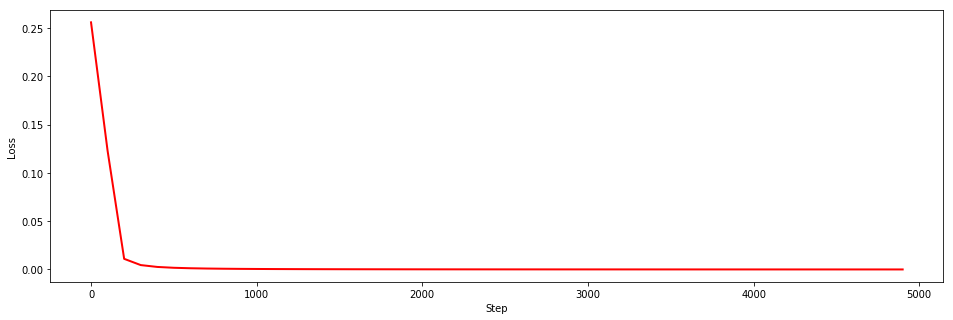

In [54]:
PlotLoss(loss_trace, 100)

In [55]:
xnor_vals = []
span = np.linspace(0, 1, 20)
with tf.variable_scope("xnor", reuse=True) as scope:
    model = CreateModel(X, layer1_width)
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, "/tmp/xnor.ckpt")
        x1, x2 = np.meshgrid(span, span)
        X_in = np.column_stack([x1.flatten(), x2.flatten()])
        xnor_vals = np.reshape(sess.run(model, feed_dict={X: X_in}), x1.shape)

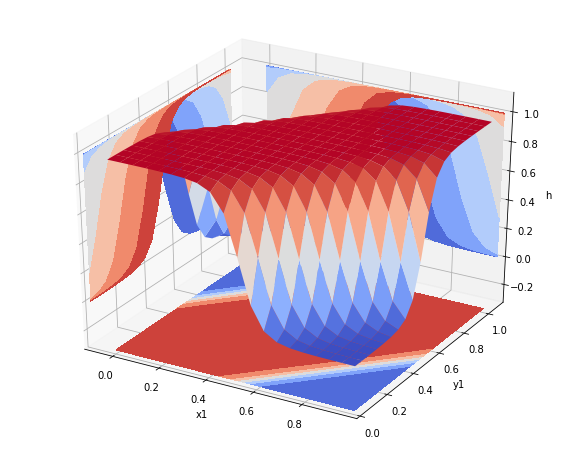

In [56]:
PlotValues(span, xnor_vals)

In [57]:
print " x1| x2| XNOR"
print "---+---+------"
print " 0 | 0 | %.3f" % xnor_vals[0][0]
print " 0 | 1 | %.3f" % xnor_vals[0][-1]
print " 1 | 0 | %.3f" % xnor_vals[-1][0]
print " 1 | 1 | %.3f" % xnor_vals[-1][-1]

 x1| x2| XNOR
---+---+------
 0 | 0 | 0.996
 0 | 1 | 0.005
 1 | 0 | 0.004
 1 | 1 | 0.996
